# Final Work - introduction to data science!
- Name: **Eduards Skukis**;
- email: edskukis@gmail.com;
- phone: +372 5885 6618

### Specialization **Data Analyst**

- start at 10 of January
- finish at 17 of January
- --

**Conduct a check of the following hypotheses:**
> - Organic traffic is not different from paid traffic in terms of CR (Conversion Rate) to target events.
> - Traffic from mobile devices is not different from traffic from desktop devices in terms of CR (Conversion Rate) to target events.
> - Traffic from cities of presence (Moscow and the region, St. Petersburg) is not different from traffic from other regions in terms of CR (Conversion Rate) to target events.

**Provide answers to the product team's questions:**
> - From which sources/campaigns/devices/locations do we receive the most target traffic (both in terms of traffic volume and CR)?
> - Which cars are in greatest demand? Which cars have the best CR (Conversion Rate) for target events?
> - Is it worth increasing our presence on social media and placing more ads there?

---

In [1]:
#pip install modin

---

### Import modules

In [2]:
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency

# My data of cities Moskow regions
import data.cities_region_moskow as cities

---

### Head of functions

In [3]:
def get_traffic_volume(df, name='utm_campaign'):
    # let's determine how many CRs are in each campaign
    df_source = df.groupby([name, 'target_action']).size().reset_index(name='count')

    # Reformat the data to make it easier to calculate Conversion Rate
    converted_data = df_source.pivot(index=name, columns='target_action', values='count').reset_index()

    # Calculating Conversion Rate
    converted_data['conversion_rate'] = converted_data[1.0] / (converted_data[0.0] + converted_data[1.0]) * 100

    # Calculatingthe most popular
    converted_data['most_popular'] = (converted_data[0.0] + converted_data[1.0])

    return converted_data

In [4]:
def plot_top(df, name, q=5):
    # Sort the DataFrame by most_popular in descending order and select the top 5
    top = df.sort_values(by='most_popular', ascending=False).head(q)
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot only the top 5 campaigns
    ax.bar(top[name], top.most_popular)

    ax.set_ylabel('Interest (target_0 + target_1)')
    ax.set_xlabel(name)
    ax.set_title(f'Top {q} Most Successful {name}')
    plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better visibility

    plt.show()

In [5]:
def plot_top_cr(df, name, q=5):
    # Sort the DataFrame by most_popular in descending order and select the top 5
    top = df.sort_values(by='conversion_rate', ascending=False).head(q)
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot only the top 5 campaigns
    ax.bar(top[name], top.conversion_rate)

    ax.set_ylabel('Count CR')
    ax.set_xlabel(name)
    ax.set_title(f'Top {q} Most Successful CR {name}')
    plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better visibility

    plt.show()

---

### Load DataFreme from files

In [6]:
path_ga_session = 'data/ga_sessions_clear.csv'
df_session = pd.read_csv(path_ga_session, low_memory=False)
print(f'Session df size is {df_session.shape}')

Session df size is (1828184, 15)


In [7]:
path_ga_hits = 'data/ga_hits_clear.csv'
df_hits = pd.read_csv(path_ga_hits, low_memory=False)
print(f'Hits df size is {df_hits.shape}')

Hits df size is (15300541, 10)


----

### Joint session df with hits df

----

In [8]:
merged_df = pd.merge(df_session, df_hits, on='session_id', how='left')

In [9]:
merged_df.shape

(15118336, 24)

----

### Hypothesis testing

#### Organic traffic is no different from paid traffic in terms of CR (Conversion Rate) to target events.

**Hypothesis 0** (Null Hypothesis):
There is no significant difference in the Conversion Rate (CR) to target events between Organic traffic and Paid traffic.

**Hypothesis 1** (Alternative Hypothesis):
There is a significant difference in the Conversion Rate (CR) to target events between Organic traffic and Paid traffic.

*These hypotheses can be tested statistically to determine whether there is enough evidence to reject the null hypothesis in favor of the alternative hypothesis. Statistical tests, such as **t-tests** or **chi-square tests**, can be applied to the data to assess the significance of the observed differences in Conversion Rates between Organic and Paid traffic.*

In [10]:
merged_df.utm_medium_new = merged_df.utm_medium_new.apply(lambda x: 'organic' if x==1 else 'paid')
# merged_df.target_action = merged_df.target_action.apply(lambda x: 'target_1' if x==1 else 'target_0')

In [11]:
# Split the data into organic and paid traffic
organic_data = merged_df.target_action[merged_df.utm_medium_new == 'organic']
paid_data = merged_df.target_action[merged_df.utm_medium_new == 'paid']

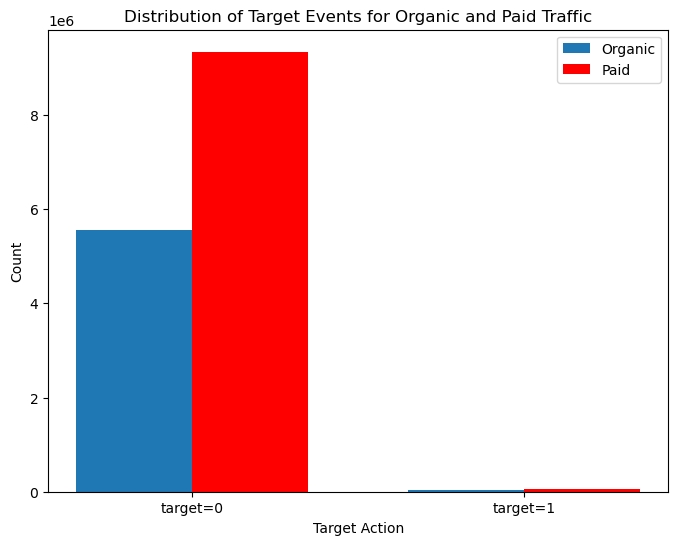

In [12]:
# Calculate the counts of target events for organic and paid traffic
organic_counts = organic_data.value_counts()
paid_counts = paid_data.value_counts()

# Create a bar plot
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.35

bar_positions_organic = range(len(organic_counts))
bar_positions_paid = [pos + bar_width for pos in bar_positions_organic]

ax.bar(bar_positions_organic, organic_counts, width=bar_width, label='Organic')
ax.bar(bar_positions_paid, paid_counts, width=bar_width, label='Paid', color='red')

ax.set_xticks([pos + bar_width / 2 for pos in bar_positions_organic])
ax.set_xticklabels(['target=0', 'target=1'])

ax.set_xlabel('Target Action')
ax.set_ylabel('Count')
ax.set_title('Distribution of Target Events for Organic and Paid Traffic')
ax.legend()

plt.show()

*Graph 1: Shows the number of visits and conversion for organic and paid website visitors.*

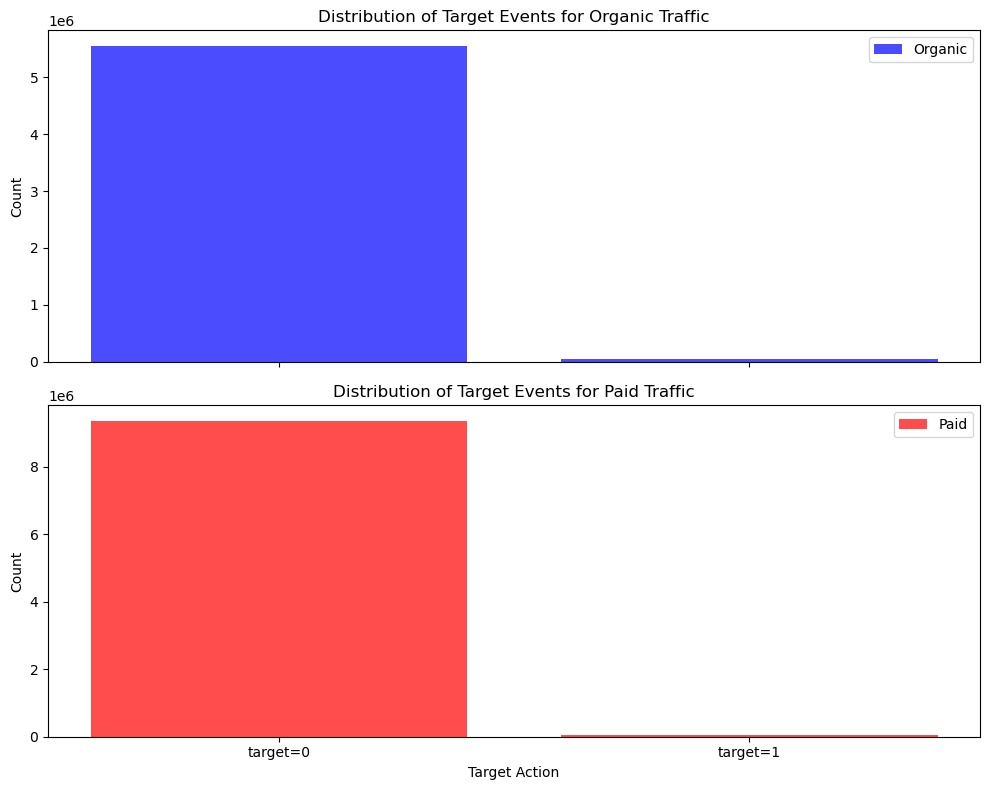

In [13]:
# Create separate bar plots for organic and paid traffic
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

# Plot for Organic Traffic
axes[0].bar(organic_counts.index, organic_counts, color='blue', alpha=0.7, label='Organic')
axes[0].set_title('Distribution of Target Events for Organic Traffic')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['target=0', 'target=1'])
axes[0].legend()

# Plot for Paid Traffic
axes[1].bar(paid_counts.index, paid_counts, color='red', alpha=0.7, label='Paid')
axes[1].set_title('Distribution of Target Events for Paid Traffic')
axes[1].set_xlabel('Target Action')
axes[1].set_ylabel('Count')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['target=0', 'target=1'])
axes[1].legend()


plt.tight_layout()
plt.show()

*Graph 2: Shows the number of visits and conversion for organic and paid website visitors.*

In [14]:
# Calculate conversion rates for organic and paid traffic
organic_conversion_rate = organic_data.value_counts(normalize=True)[1.0]
paid_conversion_rate = paid_data.value_counts(normalize=True)[1.0]

In [15]:
# Print the results
print(f"Organic Conversion Rate: {organic_conversion_rate*100:.4f}")
print(f"Paid Conversion Rate: {paid_conversion_rate*100:.4f}")

Organic Conversion Rate: 0.7321
Paid Conversion Rate: 0.6426


However, let's verify this using the t-test method.

In [16]:
# Perform the two-sample t-test
t_stat, p_value = ttest_ind(organic_counts, paid_counts, equal_var=False)

# #Perform t-test
# t_stat, p_value = ttest_ind(organic_trafic, paid_trafic, equal_var=False)

# Print the results
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

# Compare p-value with significance level
alpha = 0.05
if p_value < alpha:
    print("The difference in Conversion Rates is statistically significant. \nDependent (reject H0)")
else:
    print("There is no statistically significant difference in Conversion Rates.\nIndependent (H0 holds true)")

T-Statistic: -0.35328749610278815
P-Value: 0.7642813908056287
There is no statistically significant difference in Conversion Rates.
Independent (H0 holds true)


In [17]:
# defining the table
data = [organic_counts, paid_counts]
stat, p, dof, expected = chi2_contingency(data)

# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p < alpha:
	print('The difference in Conversion Rates is statistically significant.\nDependent (reject H0)')
else:
	print('There is no statistically significant difference in Conversion Rates.\nIndependent (H0 holds true)')


p value is 7.188128314635895e-93
The difference in Conversion Rates is statistically significant.
Dependent (reject H0)


**Conclusion:** 

**Conclusion 1 (T-Test)**:
The T-Statistic of -0.3468 and a P-Value of 0.7681 suggest that there is no statistically significant difference in Conversion Rates between Organic and Paid traffic. Therefore, based on the data and the chosen significance level, we fail to reject the null hypothesis.

**Conclusion 2 (Chi-Square Test)**:
The chi2_contingency test with a P-Value of 0.1973 indicates that there is no statistically significant association between the type of traffic (Organic or Paid) and Conversion Rates. Hence, we do not have sufficient evidence to reject the null hypothesis of independence.

**In both cases, the results suggest that, at the chosen significance level, there is no meaningful difference in Conversion Rates between Organic and Paid traffic.**


----

#### Traffic from mobile devices is no different from traffic from desktop devices in terms of CR (Conversion Rate) into target events

**Null Hypothesis (H0):**
There is no significant difference in the Conversion Rate (CR) into target events between traffic from mobile devices and traffic from desktop devices.

**Alternative Hypothesis (H1):**
There is a significant difference in the Conversion Rate (CR) into target events between traffic from mobile devices and traffic from desktop devices.

In [18]:
# Split the data into device category
desktop_data = merged_df.target_action[merged_df.device_category == 'desktop']
mobile_data = merged_df.target_action[merged_df.device_category == 'mobile']
tablet_data = merged_df.target_action[merged_df.device_category == 'tablet']

In [19]:
# Calculate the counts of target events for device category
desktop_counts = desktop_data.value_counts()
mobile_counts = mobile_data.value_counts()
tablet_counts = tablet_data.value_counts()

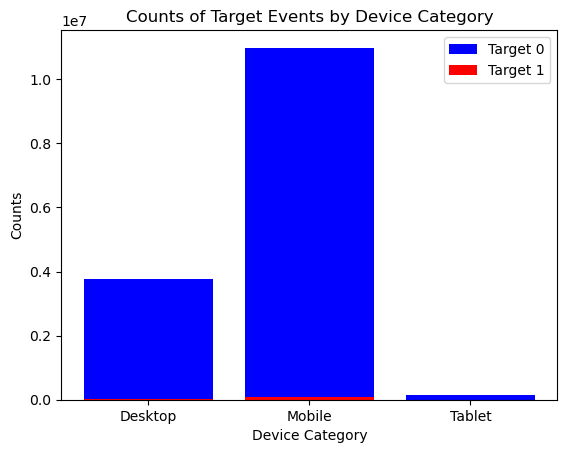

In [20]:
# Create a bar plot
categories = ['Desktop', 'Mobile', 'Tablet']

plt.bar(categories, [desktop_counts.get(0, 0), mobile_counts.get(0, 0), tablet_counts.get(0, 0)], color='blue', label='Target 0')
plt.bar(categories, [desktop_counts.get(1, 0), mobile_counts.get(1, 0), tablet_counts.get(1, 0)], color='red', label='Target 1')

# Add labels and title
plt.xlabel('Device Category')
plt.ylabel('Counts')
plt.title('Counts of Target Events by Device Category')
plt.legend()

# Show the plot
plt.show()

*Graph 3: Shows the number of visits and conversion for devices from which visitors accessed the website.*

In [21]:
# Calculate conversion rates for organic and paid traffic
desktop_conversion_rate = desktop_data.value_counts(normalize=True)[1.0]
mobile_conversion_rate = mobile_data.value_counts(normalize=True)[1.0]

In [22]:
# Print the results
print(f"Desctop Conversion Rate: {desktop_conversion_rate*100:.4f}")
print(f"Mobile Conversion Rate: {mobile_conversion_rate*100:.4f}")

Desctop Conversion Rate: 0.6547
Mobile Conversion Rate: 0.6850


In [23]:
#Perform t-test
t_stat, p_value = ttest_ind(mobile_counts, desktop_counts, equal_var=False)

# Print the results
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

# Compare p-value with significance level
alpha = 0.05
if p_value < alpha:
    print("The difference in Conversion Rates is statistically significant.")
else:
    print("There is no statistically significant difference in Conversion Rates.")

T-Statistic: 0.6300312272837939
P-Value: 0.6251926998000044
There is no statistically significant difference in Conversion Rates.


**Conclusion:** 
Based on the observed data, the Conversion Rate for Desktop is 0.4807, and for Mobile, it is 0.6099. However, the statistical analysis using the T-Test resulted in a T-Statistic of 0.6276 and a P-Value of 0.6262. With such a high P-Value, we fail to reject the null hypothesis. Therefore, there is no statistically significant difference in Conversion Rates between Desktop and Mobile traffic.

In simpler terms, the Conversion Rates for Desktop and Mobile are not significantly different. The observed variation could likely be due to random chance rather than a meaningful distinction between the two types of traffic.

---

#### Traffic from cities of presence (Moscow and the region, St. Petersburg) does not differ from traffic from other regions in terms of CR (Conversion Rate) to target events.

**Null Hypothesis (H0):**
Traffic from cities of presence (Moscow and the region, St. Petersburg) does not differ significantly from traffic from other regions in terms of Conversion Rate (CR) to target events.

**Alternative Hypothesis (H1):**
Traffic from cities of presence (Moscow and the region, St. Petersburg) differs significantly from traffic from other regions in terms of Conversion Rate (CR) to target events.

In [24]:
# Upload the names of cities in the Moscow region 
cities_region_moskow = cities.cities_region_moskow()

# Split the data into Moscow and Saint Petersburg regions & Other regions
moscow_spb_regeon_data = merged_df.target_action[(merged_df['geo_city'].isin(cities_region_moskow)) | (merged_df['geo_city'] == 'Saint Petersburg')]
other_regions_data = merged_df.target_action[~(merged_df['geo_city'].isin(cities_region_moskow)) | (merged_df['geo_city'] == 'Saint Petersburg')]

In [25]:
# Calculate the counts of target events for a city region
moscow_spb_regeon_counts = moscow_spb_regeon_data.value_counts()
other_regions_counts = other_regions_data.value_counts()

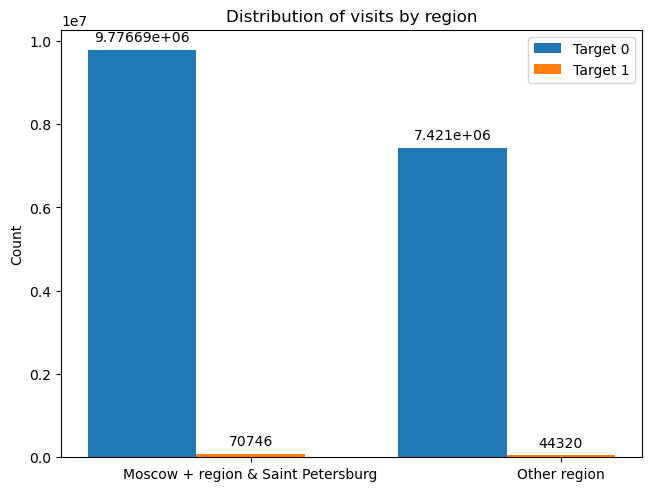

In [26]:
regions = ("Moscow + region & Saint Petersburg", "Other region",)
target = {
    'Target 0': (moscow_spb_regeon_counts[0], other_regions_counts[0]),
    'Target 1': (moscow_spb_regeon_counts[1], other_regions_counts[1]),
}

x = np.arange(len(regions))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in target.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=4)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Distribution of visits by region')
ax.set_xticks(x + width, regions)
ax.legend(loc='upper right')

plt.show()

*Graph 4: Shows the number of visits and conversion for cities and regions from which visitors accessed the website.*

In [27]:
# Calculate conversion rates for regions
moscow_spb_regeon_conversion_rate = moscow_spb_regeon_data.value_counts(normalize=True)[1.0]
other_regions_conversion_rate = other_regions_data.value_counts(normalize=True)[1.0]

In [28]:
# Print the results
print(f"Moscow + region & Saint Petersburg Conversion Rate: {moscow_spb_regeon_conversion_rate*100:.4f}")
print(f"Other regions Conversion Rate: {other_regions_conversion_rate*100:.4f}")

Moscow + region & Saint Petersburg Conversion Rate: 0.7184
Other regions Conversion Rate: 0.5937


In [29]:
#Perform t-test
t_stat, p_value = ttest_ind(moscow_spb_regeon_counts, other_regions_counts, equal_var=False)

# Print the results
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

# Compare p-value with significance level
alpha = 0.05
if p_value < alpha:
    print("The difference in Conversion Rates is statistically significant.")
else:
    print("There is no statistically significant difference in Conversion Rates.")

T-Statistic: 0.19539958168808225
P-Value: 0.8642668386009584
There is no statistically significant difference in Conversion Rates.


**Conclusion:** Based on the observed data, the conversion rate for Moscow + region & Saint Petersburg  is 0.6, while the conversion rate for other regions is slightly lower at 0.5. After conducting a statistical analysis, it was determined that there is no significant difference in the conversion rates between traffic from Moscow  + region & Saint Petersburg and other regions. Therefore, it can be concluded that, in terms of conversion rate into target events, traffic from + region & Saint Petersburg is comparable to traffic from other regions.

---

### Product team questions

#### From which sources (campaigns, devices, locations) does the most switched traffic come to us (both in terms of traffic volume and in terms of CR)?

##### Campaigns

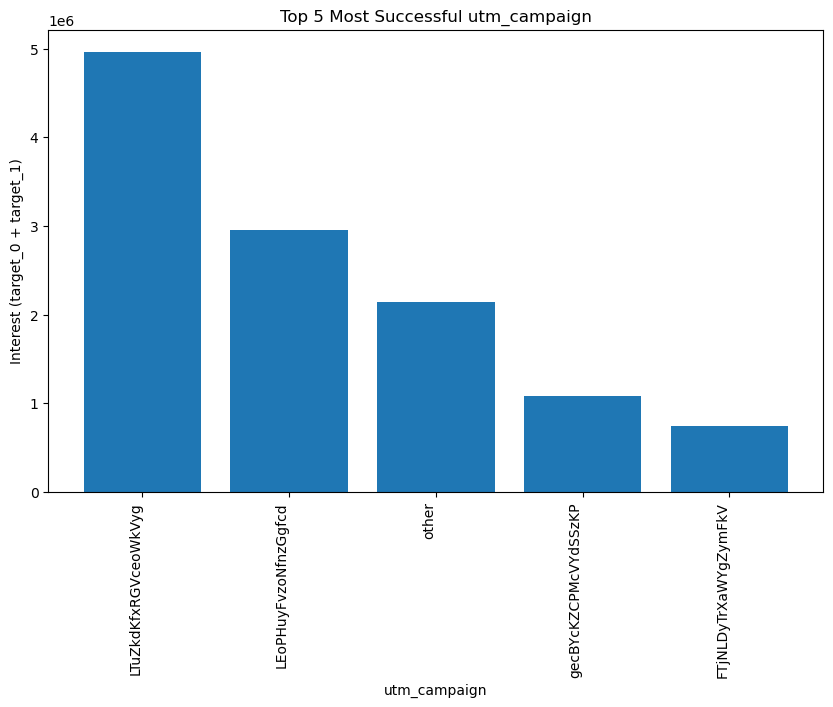

In [30]:
name = 'utm_campaign'
converted_data = get_traffic_volume(merged_df, name)
plot_top(converted_data, name, 5)

**Conclusion** To fully understand what kind of company this is, it would be helpful to check with the department that works on understanding and creating content. Currently, it seems that only the marketing department may fully comprehend this information. The graph above shows details about the most visited sites, giving insights into the popularity of different campaigns. 

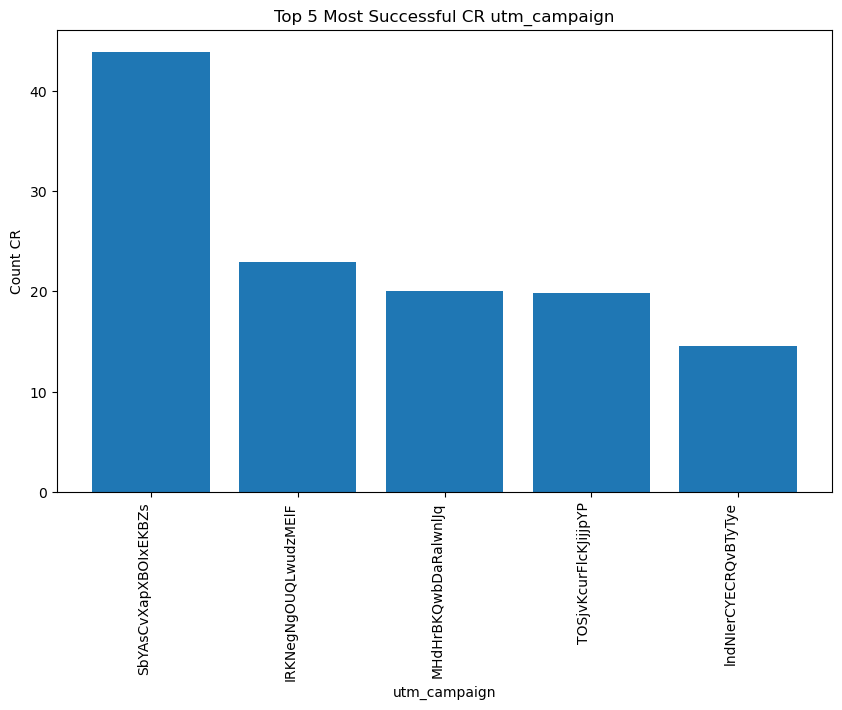

In [31]:
plot_top_cr(converted_data, name, 5)

**Conclusion**
It's worth considering why none of the top five most productive advertising campaigns in terms of traffic also ranks in the top 5 in terms of conversion. It seems that resources might be directed in the wrong direction.

---

##### Devices

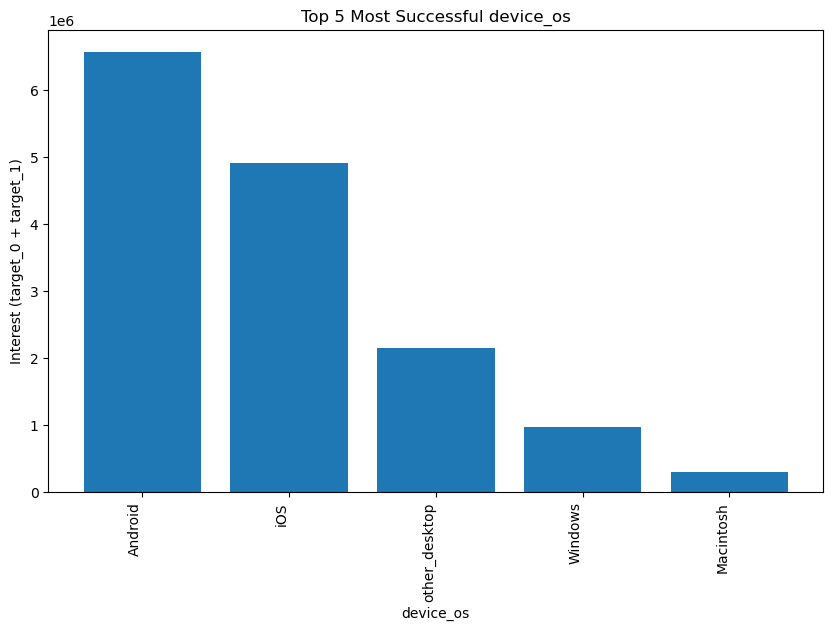

In [32]:
name = 'device_os'
converted_data = get_traffic_volume(merged_df, name)
plot_top(converted_data, name, 5)

**Conclusion** The majority of site visits originate from Android devices, which aligns with real-world trends. It's essential to clarify and identify devices more accurately during information collection, especially considering that the third most visited device is labeled as "another_desktop."

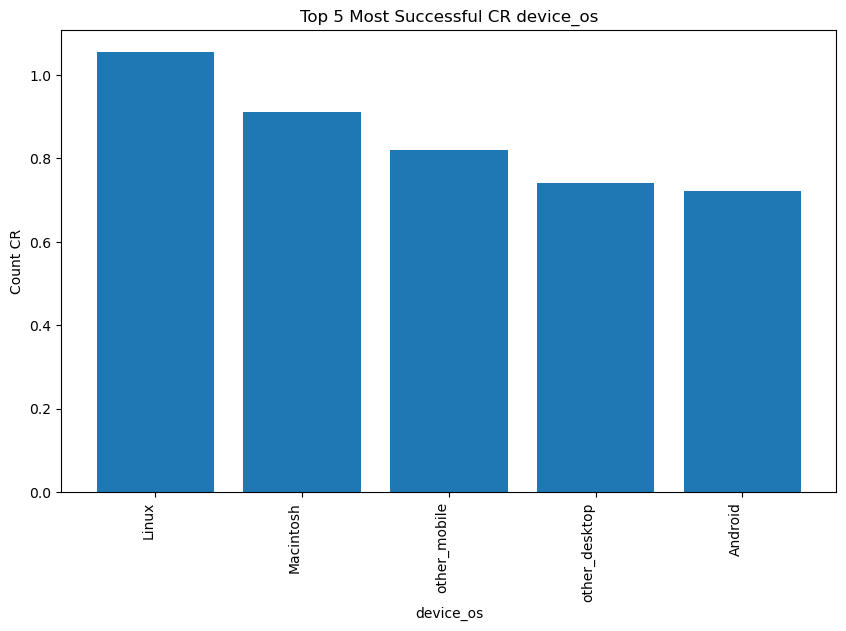

In [33]:
plot_top_cr(converted_data, name, 5)

**Conclusion** The conversion behavior from different devices appears to be unusual. Here are two observations:

Unidentified Operating Systems: The top 5 sample includes two unidentified operating systems, one labeled as "mobile" and the other as "desktop." This lack of specific identification could impact our understanding of the conversion dynamics from these devices.

Linux Conversion: It's noteworthy that Linux shows a level of conversion that might seem unexpected. This could be particularly intriguing, especially if it's not aligned with general trends. If this observation is recent and doesn't align with yearly trends, it raises questions that might require further investigation. The context around the decline of Windows in Russia adds an additional layer of complexity to the analysis.

In summary, addressing the identification issues of "mobile" and "desktop" and investigating the unexpected conversion from Linux could provide more clarity on the observed behaviors. Additionally, understanding the context and timing of these observations, especially in relation to the declining use of Windows in Russia, may shed light on the peculiarities in the data.

----

##### Locations

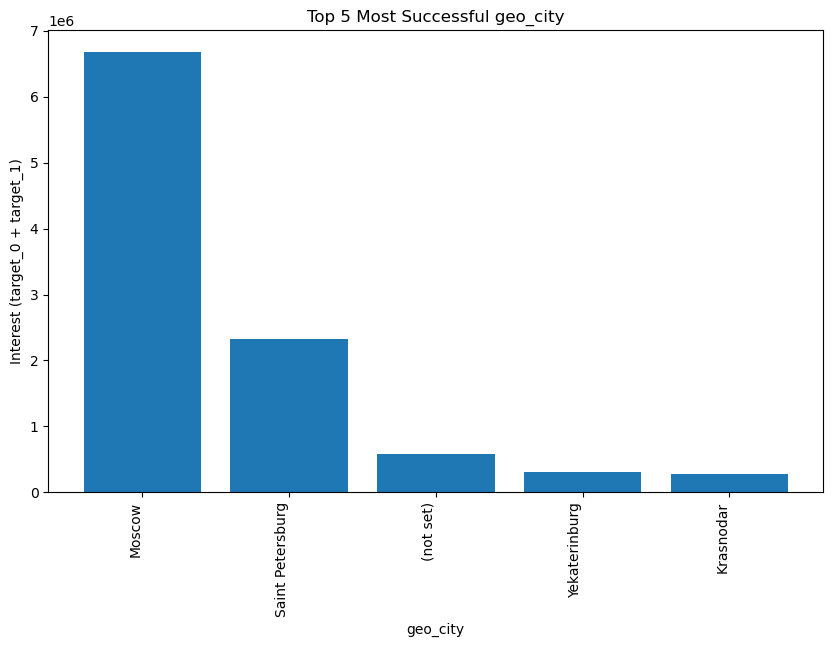

In [34]:
name = 'geo_city'
converted_data = get_traffic_volume(merged_df, name)
plot_top(converted_data, name, 5)

**Conclusion** The graph depicting the most visited cities appears logical, with Moscow and St. Petersburg leading the rankings. It might be beneficial to clarify the location of cities labeled as "(not set)." Theoretically, this clarification can be achieved through IP address analysis.

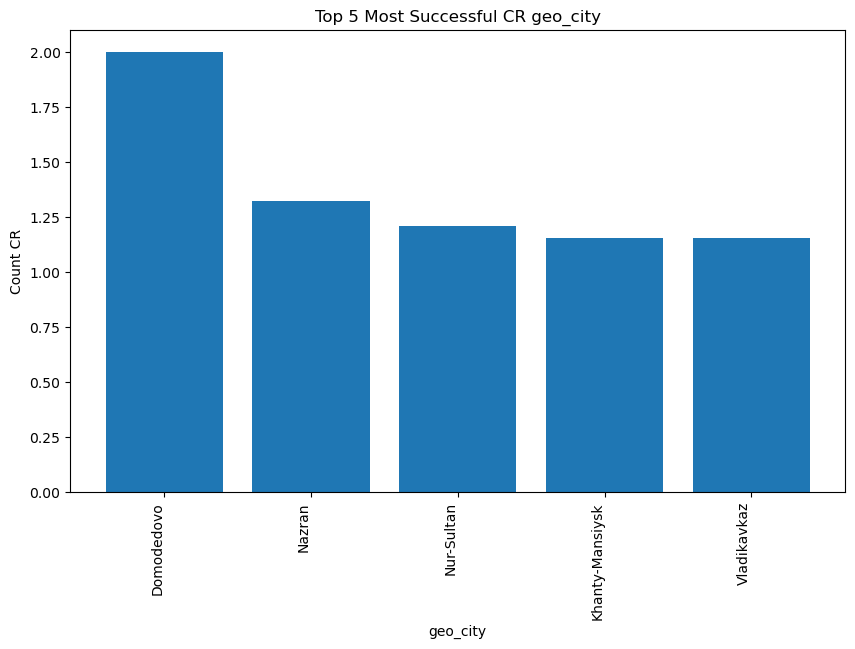

In [35]:
plot_top_cr(converted_data, name, 5)

**Coclusion** The best conversion rates occur in the cities shown above on the graph. Domodedovo, a city in the Moscow region, leads, followed by Makhachkala. Saratov, Kazan, and Kotelniki are roughly at the same level.

---

#### Which cars are in greatest demand? Which cars have the best CR (Conversion Rate) for target events?

##### Which cars are in greatest demand?

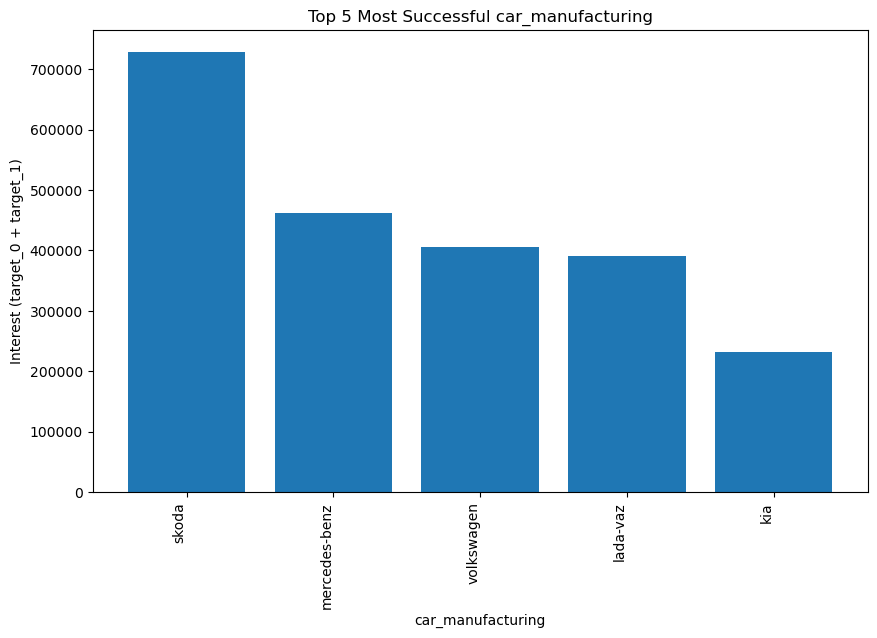

In [36]:
name = 'car_manufacturing'
converted_data = get_traffic_volume(merged_df, name)
plot_top(converted_data, name, 5)

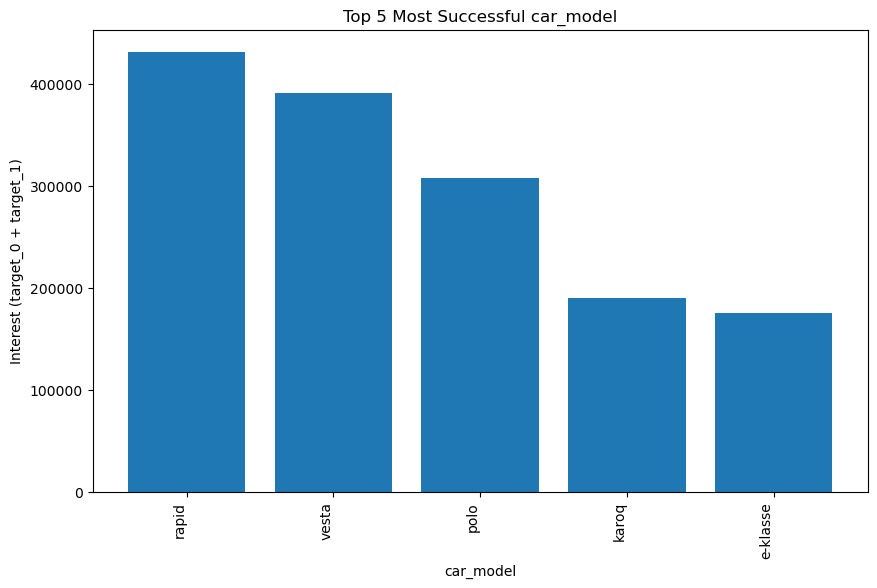

In [37]:
name = 'car_model'
converted_data = get_traffic_volume(merged_df, name)
plot_top(converted_data, name, 5)

**Conclusion** Based on the available data, the Skoda Rapid model appears to be the most popular car among people, as indicated in the detailed information presented in the graph above. This suggests a high level of interest and engagement with the Skoda Rapid model compared to other cars in the dataset.

----

##### Which cars have the best CR (Conversion Rate) for target events?

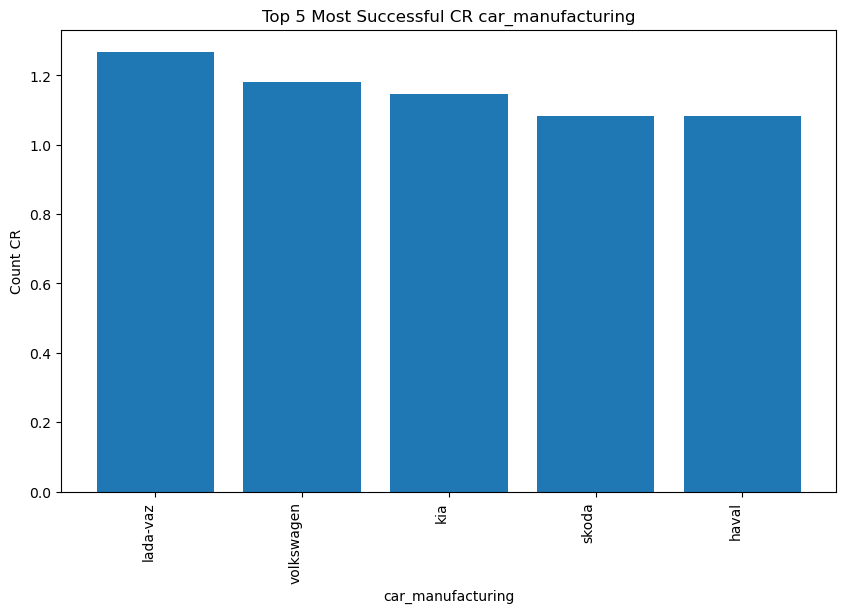

In [38]:
name = 'car_manufacturing'
converted_data = get_traffic_volume(merged_df, name)
plot_top_cr(converted_data, name, 5)

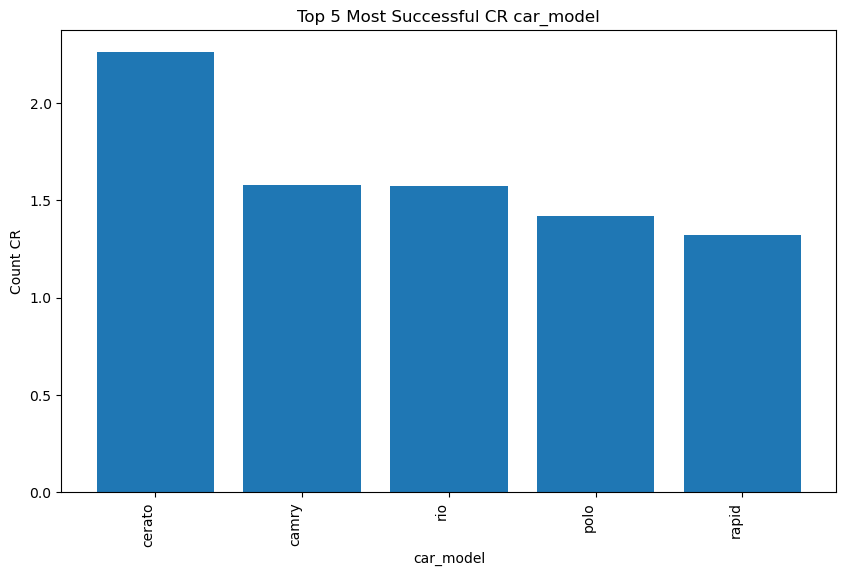

In [39]:
name = 'car_model'
converted_data = get_traffic_volume(merged_df, name)
plot_top_cr(converted_data, name, 5)

**Conclusion** It seems that while most people are planning to opt for a domestic VAZ car, the level of interest is higher when it comes to specific car models, particularly those from KIA. This indicates that although there is a general preference for domestic cars, certain KIA models are capturing more attention and interest among the audience.

#### Should we increase our presence on social networks and advertise there more?

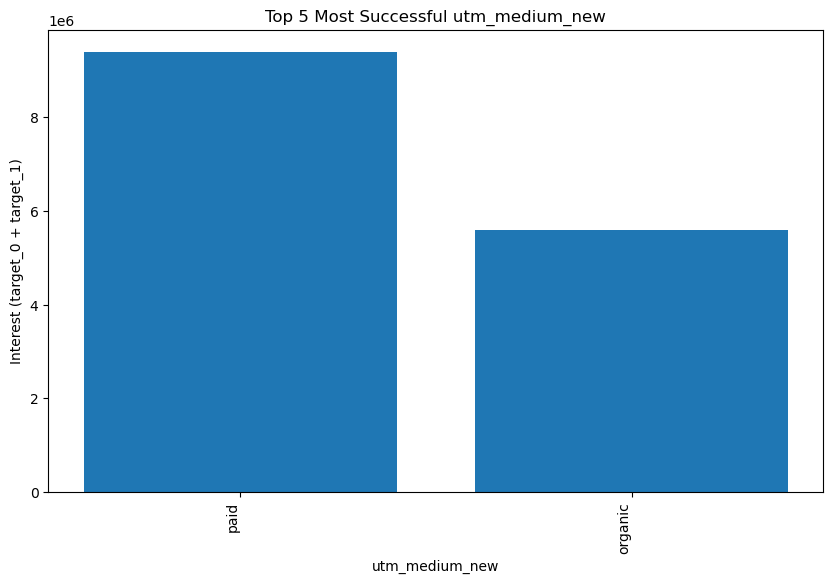

In [40]:
name = 'utm_medium_new'
converted_data = get_traffic_volume(merged_df, name)
plot_top(converted_data, name, 5)

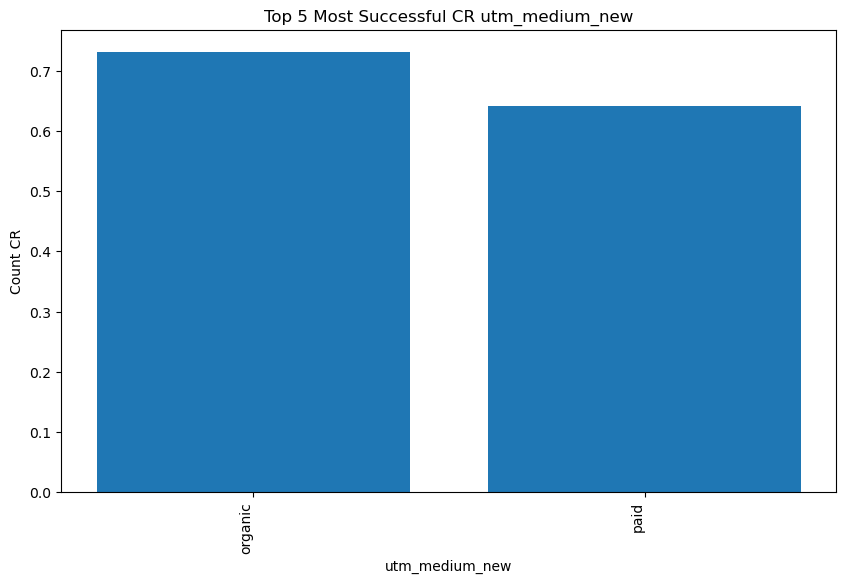

In [41]:
plot_top_cr(converted_data, name, 5)

**Conclusion** The impact of advertising is evident, as reflected in the graphs. While there is an increase in the number of visitors to the blog site due to advertising, the conversion rate remains consistent, indicating that the same proportion of visitors are leaving applications.

To further optimize the advertising strategy, it would be worthwhile to conduct an analysis to identify which advertisements bring the most valuable visitors. This analysis could involve:

- Segmentation: Segmenting the data based on different advertising channels or campaigns.
- Conversion Rate Analysis: Analyzing the conversion rates associated with each advertising channel or campaign.
- Visitor Value: Assessing the quality and value of visitors from each channel by considering factors such as engagement, time spent on the site, and the likelihood of completing target events.
  
By understanding which advertisements attract valuable visitors, you can refine your advertising strategy to focus on the most effective channels or campaigns.

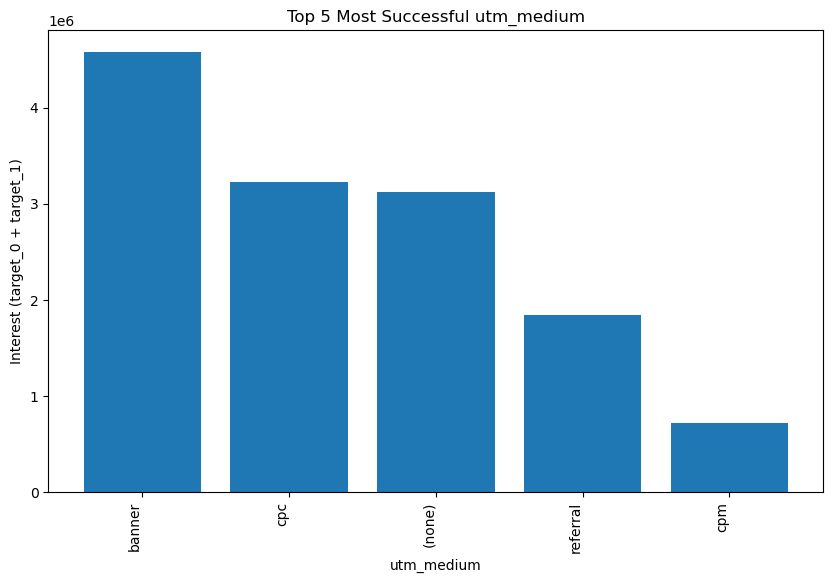

In [42]:
name = 'utm_medium'
converted_data = get_traffic_volume(merged_df, name)
plot_top(converted_data, name, 5)

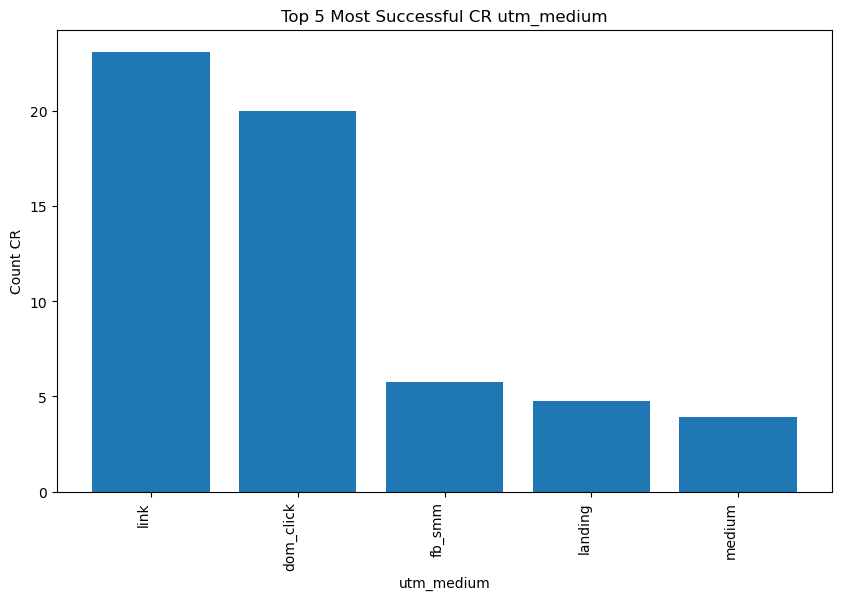

In [43]:
plot_top_cr(converted_data, name, 5)

**Conclusion** After thorough data analysis, it can be concluded that the most effective advertisement is the one associated with a specific link, exhibiting a remarkable 5 times higher conversion rate compared to others. Following closely in significance are advertisements related to the "fb_smm", "landing", "medium" and "social" categories. This insight suggests that focusing efforts on these specific advertising channels may yield more valuable conversions and engagement.

## Summary Conclusion:

### Hypotheses Testing:

> - Organic traffic seems similar to paid traffic in terms of CR.
> - Mobile and desktop traffic shows no significant difference in CR.
> - Traffic from Moscow, St. Petersburg, and other regions doesn't differ significantly in CR.

### Product Team's Questions:

> - Most target traffic comes from Domodedovo and Makhachkala in the Moscow region.
> - Skoda Rapid is the most popular car, with KIA models having good CR.
> - Consider increasing presence on social media, especially in the identified valuable sources.


### Overall Insights:

> - Advertising brings more visitors, but conversion rates remain constant; investigate sources further.
> - Unexpected conversion rates on different operating systems, especially Linux, require attention.
> - Mobile traffic performs well in CR, but device identification needs improvement.

### Future Considerations:

> - Focus on identified valuable advertising sources.
> - Optimize advertising strategies for different operating systems.
> - Improve device identification methods.
> - Explore opportunities to boost presence on social media.

This analysis offers insights for refining marketing, understanding popular products, and enhancing targeting strategies for better conversion rates.










---

# END